In [1]:
# Uncomment pyximport to compile instead of running pure python
#import pyximport; pyximport.install(language_level=3)

from matplotlib import pyplot as plt
from py_ballisticcalc import Velocity, Distance, Angular
from py_ballisticcalc import DragModel, TableG7
from py_ballisticcalc import Ammo
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import Settings as Set

Default units:
angular = degree
distance = yard
velocity = fps
pressure = inHg
temperature = fahrenheit
diameter = inch
length = inch
weight = grain
adjustment = mil
drop = inch
energy = foot-pound
ogw = pound
sight_height = inch
target_height = inch
twist = inch


In [ ]:
# Define standard .308
dm = DragModel(0.22, TableG7, 168, 0.308)
ammo = Ammo(dm, 1.22, Velocity(2600, Velocity.FPS))

# Establish 100-yard zero
weapon = Weapon(4, 100, 12, Angular.Mil(0))
calc = Calculator(weapon, ammo)
zero_elevation = calc.elevation
print(f'Barrel elevation for zero: {zero_elevation << Angular.MOA}')

In [2]:
# Plot trajectory out to 500 yards
shot = Shot(500, zero_angle=calc.elevation, relative_angle=Angular.Mil(0))
shot_result = calc.fire(shot, 0, extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(
    Distance.Yard(300), Distance.Meter(.5), Angular.Mil(0)
)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax)
plt.show()

Barrel elevation for 100.0yd zero: 1.33mil


In [ ]:
# Now find the elevation needed to hit a target at 200 yards with 10-degree look angle
weapon = Weapon(4, 200, 12, Angular.Degree(10))
calc = Calculator(weapon, ammo)
zero_elevation = calc.elevation
print(f'To hit target at {weapon.zero_distance << Set.Units.distance} sighted at a ' 
      f'{weapon.zero_look_angle << Angular.Degree} look angle, Barrel elevation={zero_elevation << Angular.Degree}')

Danger space at 300.0yd for 19.7inch tall target ranges from 217.1yd to 355.8yd


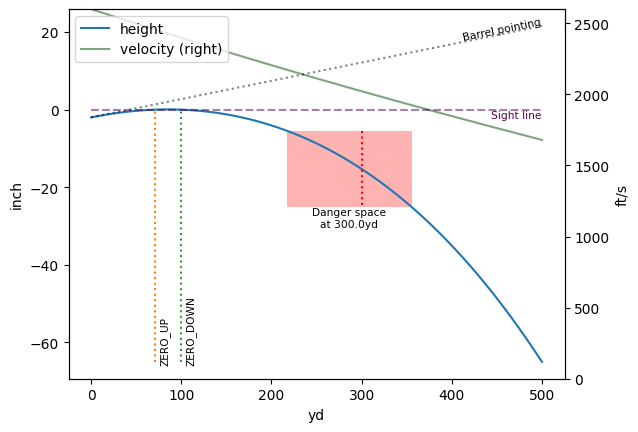

In [3]:
shot = Shot(900, zero_angle=calc.elevation)
shot_result = calc.fire(shot, 0, extra_data=True)
ax = shot_result.plot()
# Find danger space for a target at 500 yards
danger_space = shot_result.danger_space(
    Distance.Yard(300), Distance.Meter(.5), calc.weapon.zero_look_angle
)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax)
plt.show()

In [ ]:
shot_result.dataframe.to_clipboard()

,time,velocity,mach,target_drop,drop_adj,windage,windage_adj,angle,drag
distance,,,,,,,,,
0.0 yd,0.000 s,2600.0 ft/s,2.33 mach,-2.0 inch,0.00 mil,0.0 inch,0.00 mil,0.0750 °,0.000
100.0 yd,0.120 s,2398.1 ft/s,2.15 mach,-0.0 inch,-0.00 mil,0.4 inch,0.12 mil,-0.0137 °,0.658
200.0 yd,0.251 s,2205.5 ft/s,1.98 mach,-4.1 inch,-0.57 mil,1.7 inch,0.25 mil,-0.1183 °,0.626
300.0 yd,0.393 s,2022.3 ft/s,1.81 mach,-15.3 inch,-1.44 mil,4.1 inch,0.39 mil,-0.2424 °,0.596
400.0 yd,0.548 s,1847.5 ft/s,1.65 mach,-35.0 inch,-2.48 mil,7.6 inch,0.54 mil,-0.3905 °,0.570
500.0 yd,0.718 s,1680.1 ft/s,1.50 mach,-65.0 inch,-3.68 mil,12.4 inch,0.70 mil,-0.5688 °,0.547
600.0 yd,0.906 s,1519.5 ft/s,1.36 mach,-107.3 inch,-5.06 mil,18.8 inch,0.89 mil,-0.7856 °,0.524
700.0 yd,1.114 s,1366.0 ft/s,1.22 mach,-164.8 inch,-6.66 mil,27.0 inch,1.09 mil,-1.0523 °,0.499
800.0 yd,1.347 s,1221.3 ft/s,1.09 mach,-240.9 inch,-8.52 mil,37.3 inch,1.32 mil,-1.3842 °,0.465


Zero trajectory hits -65.0inch at 500.0yd
Sight adjustment to hit 500.0yd target is -3.68mil
After adjustment: drop at 500.0yd is -0.0inch


To hit target at look-distance of 500.0yd sighted at a 25.84° look-angle, barrel elevation=4.55mil
Current zero has barrel elevated 1.33mil so hold for new shot is 3.22mil
(Horizontal component of distance to this target is 450.0yd)


,time,velocity,mach,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor
distance,,,,,,,,,,
0.0 yd,0.000 s,2600.0 ft/s,2.33 mach,-1.8 inch,0.00 mil,0.0 inch,0.00 mil,0.0 yd,26.0961 °,4.548e-05
50.0 yd,0.066 s,2485.7 ft/s,2.23 mach,6.4 inch,3.23 mil,0.1 inch,0.07 mil,55.6 yd,26.0533 °,-2.144e-03
100.0 yd,0.134 s,2374.5 ft/s,2.13 mach,13.0 inch,3.29 mil,0.5 inch,0.15 mil,111.1 yd,26.0065 °,-4.285e-03
150.0 yd,0.206 s,2266.4 ft/s,2.03 mach,17.8 inch,3.02 mil,1.2 inch,0.23 mil,166.7 yd,25.9551 °,-6.416e-03
200.0 yd,0.282 s,2161.5 ft/s,1.94 mach,20.8 inch,2.65 mil,2.2 inch,0.31 mil,222.2 yd,25.8986 °,-8.538e-03
250.0 yd,0.361 s,2059.7 ft/s,1.85 mach,21.7 inch,2.21 mil,3.5 inch,0.39 mil,277.8 yd,25.8365 °,-1.065e-02
300.0 yd,0.444 s,1960.8 ft/s,1.76 mach,20.4 inch,1.73 mil,5.1 inch,0.48 mil,333.3 yd,25.7680 °,-1.275e-02
350.0 yd,0.531 s,1864.5 ft/s,1.67 mach,16.5 inch,1.20 mil,7.1 inch,0.58 mil,388.9 yd,25.6923 °,-1.484e-02
400.0 yd,0.622 s,1770.7 ft/s,1.59 mach,9.8 inch,0.63 mil,9.5 inch,0.67 mil,444.4 yd,25.6086 °,-1.692e-02


Barrel elevation for 500.0m zero: 4.69mil
Muzzle velocity at zero temperature 5.0°C is 829.0m/s


To hit target at look-distance of 700.0m sighted at a 30.0° look-angle, barrel elevation=6.1mil
	(horizontal distance to this target is 606.2m)
Current zero has barrel elevated 4.69mil so hold for new shot is 1.41mil
Danger space at 700.0m for 4.0m tall target at 30.0° look-angle ranges from 445.9m to 824.5m


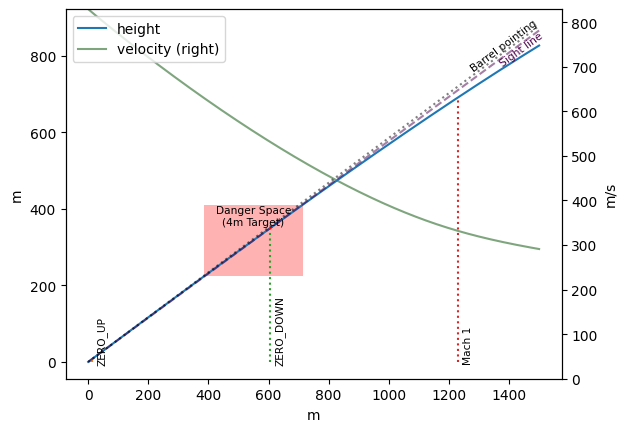

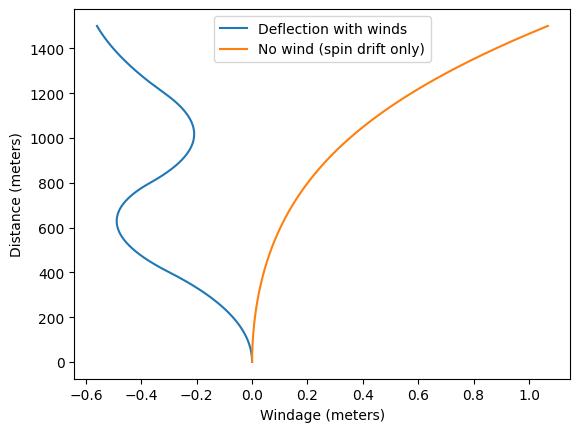

# Plot Drag Curve

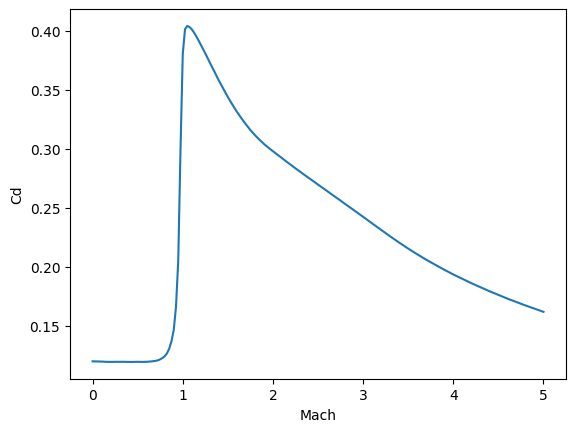

In [11]:
df = pandas.DataFrame(TableG7)
ax = df.plot(x='Mach', y='CD', ylabel='Cd', legend=False)
plt.show()

# Working With Units

In [12]:
Set.Units.distance = Unit.Foot
print(f'Default distance unit: {Set.Units.distance.name}')
# Can create value in default unit with either float or another unit of same type
print(f'\tInstantiated from float (5): {Set.Units.distance(5)}')
print(f'\tInstantiated from Distance.Line(200): {Set.Units.distance(Distance.Line(200))}')

# Ways to define value in units
# 1. old syntax
unit_in_meter = Distance(100, Distance.Meter)
# 2. short syntax by Unit type class
unit_in_meter = Distance.Meter(100)
# 3. by Unit enum class
unit_in_meter = Unit.Meter(100)
print(f'100 meters: {unit_in_meter}')
# >>> 100 meters: 100.0m

# Convert unit
# 1. by .convert()
unit_in_yards = unit_in_meter.convert(Distance.Yard)
# 2. using shift syntax
unit_in_yards = unit_in_meter << Distance.Yard  # '<<=' operator also supports
print(f'100 meters in {unit_in_yards.units.key}: {unit_in_yards}')
# >>> 100 meters in yard: 109.4yd

# Get value in specified units (as float)
# 1. by .get_in()
value_in_km = unit_in_yards.get_in(Distance.Kilometer)
# 2. by shift syntax
value_in_km = unit_in_yards >> Distance.Kilometer  # '>>=' operator also supports
print(f'100 meters, value in km: {value_in_km}  (value type is {type(value_in_km)})')
# >>> 100 meters, value in km: 0.1  (value type is <class 'float'>)

# Getting unit raw value (a float)
rvalue = Distance.Meter(100).raw_value
rvalue = float(Distance.Meter(100))
print(f'100 meters in raw value: {rvalue}  (raw type is {type(rvalue)})')
# >>> 100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)

# Comparison operators supported: < > <= >= == !=
print(f'Comparison: {unit_in_meter} == {Distance.Centimeter(100)}: {unit_in_meter == Distance.Centimeter(100)}')  # >>> False, compare two units by raw value
print(f'Comparison: {unit_in_meter} > .1*{unit_in_meter}: {unit_in_meter > .1*unit_in_meter.raw_value}')  # >>> True, compare unit with float by raw value

Default distance unit: Foot
	Instantiated from float (5): 5.0ft
	Instantiated from Distance.Line(200): 1.67ft
100 meters: 100.0m
100 meters in yard: 109.4yd
100 meters, value in km: 0.1  (value type is <class 'float'>)
100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)
Comparison: 100.0m == 100.0cm: False
Comparison: 100.0m > .1*100.0m: True
